# Bayesian Framework for Quantum Algorithms in Qiskit

## _Team: Baye's Baes_

**Team members:** _Conrad Haupt, Annie Ho, Shawal Kassim, Eric-Muthemba Kiarie, Roman Peters_

**Coach:** _Ismail Akhalwaya_


This project was developed for the Qiskit Camp Africa in 2019. It shows that Bayesian Inference can be integrated into Qiskit using the QInfer toolkit. This notebook showcases a proof-of-concept for the Iterative Quantum Phase Estimation circuit where the phase of the unitary is determined through a Sequential Monte-Carlo sampling scheme over an arbitrary prior distribution. The experimental results used for updating the posterior come from a QASM simulation of the IQPE circuit at iteration 1.

[1] N. Wiebe and C. E. Granade, “Efficient Bayesian Phase Estimation,” Phys. Rev. Lett., vol. 117, no. 1, p. 010503, Jun. 2016.

[2] C. Granade et al., “QInfer: Statistical inference software for quantum applications,” Quantum, vol. 1, p. 5, Apr. 2017.

[3] H. Abraham et al., Qiskit: An Open-source Framework for Quantum Computing. 2019.

In [128]:
# Import major packages
import qiskit as qk
import qinfer as qf
import numpy as np
import matplotlib as mpl

# Qiskit imports for IQPE
from qiskit import IBMQ
from qiskit.aqua.algorithms.single_sample import IQPE,QPE
from qiskit.aqua.components import iqfts
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.aqua.components.initial_states import Custom
from qiskit import Aer,execute
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer import noise

# QInfer imports for modelling the IQPE algorithm
from qinfer import distributions
from qinfer.smc import SMCUpdater         # The QInfer Sequantial Monte-Carlo Sampler
from qinfer import FiniteOutcomeModel

# Tertiary imports
import matplotlib.pyplot as plt
import time

# Intial setup
IBMQ.load_account()
ibmqx_provider = IBMQ.get_provider(hub='ibm-q-wits', group='internal', project='default')
mpl.rc('text', usetex=True)

/home/conrad/.anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [129]:
# Function definitions for the entire notebook
EPS = 1e-15
def chop(value):
    if np.abs(value) <= EPS:
        return 0
    else:
        return value
def radiandiff(a,b):
    FULL_ROTATION = 2 * np.pi
    return np.min(np.abs([a - b, b - a, a - b + FULL_ROTATION, b - a + FULL_ROTATION]))
def complexfromangle(angle):
    real = chop(np.real(np.exp(1.j * angle)))
    imag = chop(np.imag(np.exp(1.j * angle)))
    return real,imag

# IQPE on ZZ Unitary with specified phase

Here we setup the IQPE circuit using Aqua with an arbitrary phase

In [130]:
# Set-up unitary with specified phase
angle = 4 * np.pi / 5
real,imag = complexfromangle(angle)

PAULI_DICT_ZZ = {
    'paulis': [
        {"coeff": {"imag": imag, "real": real}, "label": "ZZ"}
    ]
}
QUBIT_OP_ZZ = WeightedPauliOperator.from_dict(PAULI_DICT_ZZ)
eigen_results = ExactEigensolver(QUBIT_OP_ZZ,4).run()
eigen_value = eigen_results['eigvals'][0]
eigen_vector = eigen_results['eigvecs'][0]

In [131]:
print('Eigenvalues',eigen_results['eigvals'])
print('Phase is %.4f radians' %(angle))

Eigenvalues [-0.80901699+0.58778525j -0.80901699+0.58778525j  0.80901699-0.58778525j
  0.80901699-0.58778525j]
Phase is 2.5133 radians


In [132]:
# Setup initial state as eigenvector
state_in = Custom(QUBIT_OP_ZZ.num_qubits, state_vector=eigen_vector)

In [133]:
# Use QASM Simulator for testing
simulator = Aer.get_backend('qasm_simulator')

In [134]:
# Construct IQPE circuit and simulate
iqpe_builder = IQPE(
    QUBIT_OP_ZZ,
    state_in,
    num_iterations=1,
    num_time_slices=1,
    expansion_mode='suzuki',
    expansion_order=1,
    shallow_circuit_concat=True)

# This is required to setup iqpe_builder so we can call construct_circuit() later on
iqpe_results = iqpe_circ = iqpe_builder.run(simulator,shots=1)

# QInfer Models and Definitions

Here we define our IQPE QInfer model as well as the required analytical representations for the inference

In [135]:
# Extend the QInfer FiniteOutcomeModel as IQPE has only one bit per measure
class IQPEModel(FiniteOutcomeModel):
    
    def __init__(self):
        super(IQPEModel, self).__init__()

    # Number of parameters overwhich to conduct the Bayesian Inference
    @property
    def n_modelparams(self):
        # phi
        return 1

    # Number of parameters that are needed for the simulation but are known.
    # i.e. do not need to be inferred
    @property
    def expparams_dtype(self):
        return [('theta','float64'), ('m','int64')]

    @property
    def is_n_outcomes_constant(self):
        return True

    # This function will verify whether the new inferred model parameters are valid for our model.
    @staticmethod
    def are_models_valid(modelparams):
        # NOTE: If T2 is included as a model parameter, restrict it to positive
        return np.logical_and(modelparams[:] >= -2*np.pi, modelparams[:]<=2*np.pi, modelparams[:] > 0).all(axis=1)

    def n_outcomes(self, expparams):
        return 2

    # This function implements our probability for reading a 0 or 1 on our IQPE circuit.
    # These equations are taken from [1] and are used by the updater/sampler to modify the posterior
    def likelihood(self, outcomes, modelparams, expparams):
        super(IQPEModel, self).likelihood(outcomes, modelparams, expparams)
        # Probability of getting 0 for IQPE is
        # P(0) = (1 + cos(M(theta - phi)))/2
        # P(1) = (1 - cos(M(theta - phi)))/2
        
        # This is the probability of getting a 0 with T2 depolarisation noise from [1].
        # Not currently used.
        # pr0 = np.exp(-expparams['m'] / expparams['T2']) * (1 + np.cos(expparams['m'] * (expparams['theta'] - modelparams[:]))) / 2 + (1 - np.exp(-expparams['m'] / expparams['T2']))/2
        
        pr0 = (1 + np.cos(expparams['m'] * (expparams['theta'] - modelparams[:]))) / 2

        return FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, pr0)

In [136]:
# As our model parameter is an angle, ensure we have the circular mean for the distribution so we allow
# for wraparound. This is done by converting angles to x,y points on a unit circle, averaging over
# x and y independently, and then combining the resulting average x and y values to create a new
# vector. If the resulting magnitude is 0, there is no circular average as all points are equi-distant.
# The resulting angle is approximately the circular average of the collection of angles/phases.
class PhaseSMCUpdater(SMCUpdater):
    @staticmethod
    def particle_mean(weights,locations):
        locs = [complexfromangle(a) for a in locations.flatten()]
        loc_x = []
        loc_y = []
        for x,y in locs:
            loc_x.append(x)
            loc_y.append(y)
        avg_x = np.average(loc_x,weights=weights)
        avg_y = np.average(loc_y,weights=weights)
        avg_angle = np.angle(avg_x + 1.j*avg_y)
        avg_mag = np.sqrt(avg_x**2 + avg_y**2)
        return avg_angle

In [137]:
# Bayesien Inference Parameters
N_PARTICLES = 5000               # number of samples for PhaseSMCUpdater
N_EXP = 25                       # Number of times to choose a new theta
USE_QISKIT_QASM_SIMULATOR = True # Toggle parameter if we don't want to run any circuit simulations
SIM_N_SHOTS=1024                 # number of shots for the circuit execution

# DType list for experiment metric logging
performance_dtype = [
    ('outcome', 'i1'),
    ('est_mean', 'f8'), ('est_cov_mat', 'f8'),
    ('true_err', 'f8'), ('resample_count', 'i8'),
    ('elapsed_time', 'f8'),
    ('like_count', 'i8'), ('sim_count', 'i8'),
    ('bme', 'f8'),
    ('var', 'f8'),
    ('bme_err', 'f8')
]
performance = np.empty((N_EXP), dtype=performance_dtype)

In [138]:
# Set-up initial prior and QInfer model
# prior = distributions.UniformDistribution([0, 2 * np.pi])
prior = distributions.NormalDistribution(angle,np.pi/4)
model = IQPEModel()

In [139]:
# Use IBMQX Rochester as the base device for the partially ideal noise-model. We 
backend_device = ibmqx_provider.get_backend('ibmq_rochester')
partially_ideal_model = noise.device.basic_device_noise_model(
    backend_device.properties(),gate_error=False,readout_error=False,
    thermal_relaxation=False,standard_gates=True)
data_backend = Aer.get_backend('qasm_simulator')

In [163]:
# Create a Bayesian Inference Updater
updater = PhaseSMCUpdater(model, N_PARTICLES, prior,zero_weight_policy='skip')
# Set-up initial experimental parameters
THETA = prior.sample()[0][0]
M = 1
T2 = 100

posterior_marginal = []
memory_list = []
theta_list = []

##############################################
# Run for each experiment we defined earlier #
##############################################
for idx_exp in range(N_EXP):
    # Define experimental parameters
    expparams = np.array([(M,THETA)], dtype=model.expparams_dtype)
    
    # Simulate IQPE circuit and get results for inference
    circuit = iqpe_builder.construct_circuit(k=M,omega=THETA,measurement=True)
    results = execute(circuit,simulator,shots=SIM_N_SHOTS,memory=True,noise_model=ideal_model)
    counts = results.result().get_counts()
    memory = results.result().get_memory()
    memory_list.append(memory)
    theta_list.append(THETA.flatten())

    # Start by simulating and recording the data. #

    # Retrieve the outcome of the simulation either from the circuit simulation or a model simulation
    if USE_QISKIT_QASM_SIMULATOR:
        outcomes = np.array([[int(m) for m in memory]])
    else:
        outcomes = model.simulate_experiment(np.array([[angle]]),expparams,repeat=SIM_N_SHOTS)
        outcomes = outcomes.reshape((1,outcomes.shape[0]))
        
    model._sim_count = 0
    model._call_count = 0

    # Time the update process
    #     tic = toc = None
    #     tic = time.time()

    # Update the posterior particles using the result of the circuit simulation
    updater.batch_update(outcomes, expparams)
    
    #     performance[idx_exp]['elapsed_time'] = time.time() - tic

    # Record the performance of this updater.
    est_mean = updater.est_mean()
    performance[idx_exp]['est_mean'] = est_mean
    performance[idx_exp]['true_err'] = radiandiff(est_mean,angle) ** 2
    performance[idx_exp]['est_cov_mat'] = updater.est_covariance_mtx()
    performance[idx_exp]['resample_count'] = updater.resample_count
    performance[idx_exp]['like_count'] = model.call_count
    performance[idx_exp]['sim_count'] = model.sim_count
    
#     Log
    print(idx_exp,'/',N_EXP,'[',M,THETA,est_mean,']')
    
    
    # Re-evaluate experiment parameters
    uniform_draw_01 = np.random.uniform(low=0.05,high=0.95)
#     uniform_draw_01 = np.random.uniform()
    cumsum_particles = np.cumsum(updater.particle_weights)
    draw_index = (cumsum_particles<= uniform_draw_01).argmin()
    THETA = updater.particle_locations[draw_index]
#     current_variance = updater.est_covariance_mtx()[0][0]
#     M=idx_exp % 6 + 1
    
    posterior_marginal.append((updater.posterior_marginal()))

print('Inference completed')

0 / 25 [ 1 2.2247863572512836 2.54531063001566 ]
1 / 25 [ 1 [2.94084272] 2.5576314486878684 ]
2 / 25 [ 1 [2.81167142] 2.5628875896183163 ]
3 / 25 [ 1 [2.27997105] 2.5656032435855853 ]
4 / 25 [ 1 [3.25967239] 2.369671933681773 ]
5 / 25 [ 1 [2.64024075] 2.392361257076481 ]
6 / 25 [ 1 [2.51572721] 2.4106386198086036 ]
7 / 25 [ 1 [2.01676131] 2.42560295657491 ]
8 / 25 [ 1 [2.4287447] 2.4380449342646493 ]
9 / 25 [ 1 [1.99341921] 2.4812820612574646 ]
10 / 25 [ 1 [2.37077158] 2.4880674161607748 ]
11 / 25 [ 1 [2.79005046] 2.4939565631141196 ]
12 / 25 [ 1 [2.81977423] 2.499101227847673 ]
13 / 25 [ 1 [2.20683687] 2.5036271556645726 ]
14 / 25 [ 1 [2.44050937] 2.5076365743992572 ]
15 / 25 [ 1 [2.64024075] 2.5112121219360324 ]
16 / 25 [ 1 [2.53116409] 2.5144206473790987 ]
17 / 25 [ 1 [2.59477881] 2.517316440536718 ]
18 / 25 [ 1 [2.43948248] 2.5199438390105096 ]
19 / 25 [ 1 [2.54266406] 2.5223392865542396 ]
20 / 25 [ 1 [2.60721876] 2.524532943365652 ]
21 / 25 [ 1 [2.62169114] 2.526549942717673 ]
22 

## Posterior Marginal for each Iteration

2.5132741228718345


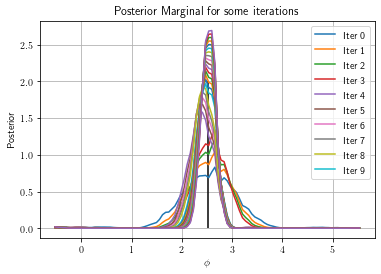

In [212]:
# Plot for each iteration
print(angle)
fig_iter = plt.figure()
ax_iter = plt.subplot(111)
for x in posterior_marginal:
#     print(x[0],x[1])
    _ = ax_iter.plot(x[0],x[1])
ax_iter.vlines(angle,ymin=0,ymax=2)
_ = ax_iter.legend(['Iter ' + str(x) for x in range(len(posterior_marginal[0:10]))])
_ = plt.grid()
_ = plt.ylabel('Posterior')
_ = plt.xlabel(r'$\phi$')
_ = plt.title('Posterior Marginal for some iterations')
plt.savefig('iterative_posterior.png',dpi=300)

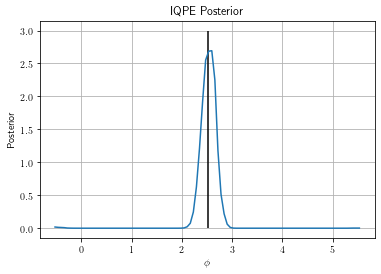

In [213]:
ax_qinfer = updater.plot_posterior_marginal(smoothing=0)
plt.vlines(angle,ymin=0,ymax=3)
plt.grid()
_ = plt.ylabel('Posterior')
_ = plt.xlabel(r'$\phi$')
_ = plt.title('IQPE Posterior')
plt.savefig('final_posterior.png',dpi=300)

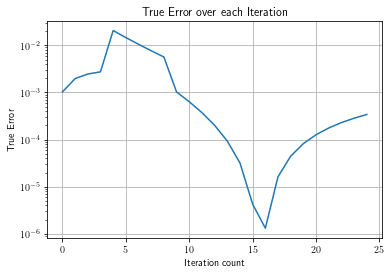

In [207]:
fig_true_err = plt.figure()
ax_true_err = plt.subplot(111)
ax_true_err.semilogy(performance['true_err'])
ax_true_err.grid()
_ = plt.xlabel('Iteration count')
_ = plt.ylabel('True Error')
_ = plt.title('True Error over each Iteration')
plt.savefig('true_error.png',dpi=300)

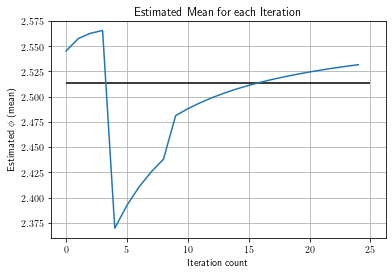

In [206]:
fig_est_mean = plt.figure()
ax_est_mean = plt.subplot(111)
ax_est_mean.plot(performance['est_mean'])
ax_est_mean.grid()
ax_est_mean.hlines(angle,xmin=0,xmax=N_EXP)
_ = plt.xlabel('Iteration count')
_ = plt.ylabel('Estimated $\phi$ (mean)')
_ = plt.title('Estimated Mean for each Iteration')
plt.savefig('mean.png',dpi=300)

# Presentation plots

In [198]:
# Calculate the naive prediction of the IQPE phase, phi
E_i = memory_list
# Convert to integers
theta_i = theta_list
phi_i = []
for i,E in enumerate(E_i):
#     print(i,E)
    e = [int(v) for v in E]

    # Naive sum
    sum = 0
    for v in e:
        sum += v
    p_i = sum / len(E)

    # Inverse naive phi approximation using expected value from experimental results
    phi = theta_i[i][0] - (np.arccos(1 - (2 * p_i))) / M
    phi_i.append(phi)

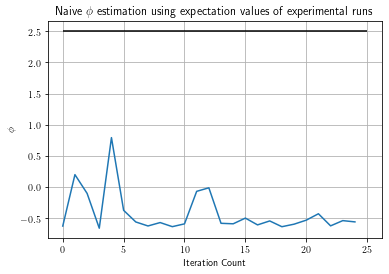

In [205]:
# Plot the naive phi estimate
plt.plot(phi_i)
plt.grid()
plt.hlines(angle,xmin=0,xmax=25)
_ = plt.xlabel('Iteration Count')
_ = plt.ylabel(r'$\phi$')
_ = plt.title('Naive $\phi$ estimation using expectation values of experimental runs')
plt.savefig('naive.png',dpi=300)

## Draw the Circuit

In [221]:
# Disable TeX text rendering
mpl.rc('text', usetex=False)

In [224]:
# Render the IQPE circuit for M=1 and the last Theta used
circuit = iqpe_builder.construct_circuit(k=1,omega=THETA,measurement=True)
circ_fig = circuit.draw(output='mpl')
circ_fig.savefig('iqpe_1.png',dpi=300)

In [225]:
# Render the IQPE circuit for M=2 and the last Theta used
circuit = iqpe_builder.construct_circuit(k=2,omega=THETA,measurement=True)
circ_fig = circuit.draw(output='mpl')
circ_fig.savefig('iqpe_2.png',dpi=300)